# SVR Model : XOM(Partial)

####  Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
style.use("fivethirtyeight")

# 1. Importing dataset

In [2]:
XOM_partial_ds=pd.read_csv('dataset/XOM.csv')

### 1.1 Date Extration Within 2018-07-12 - 2022-07-12

In [3]:
mask=(XOM_partial_ds['Date'] >= '2018-07-12') & (XOM_partial_ds['Date'] <= '2022-07-12')
XOM_partial_ds=XOM_partial_ds.loc[mask]
print(XOM_partial_ds)

             Date       Open       High        Low      Close    Volume  \
14229  2018-07-12  66.294395  66.478077  65.735350  66.038834   9762200   
14230  2018-07-13  66.030853  66.885389  65.935015  66.533989   8720000   
14231  2018-07-16  65.903063  66.118696  65.487777  65.879105   8306900   
14232  2018-07-17  65.695424  66.086751  65.519724  65.735352   7373300   
14233  2018-07-18  65.328066  65.743352  65.080487  65.663490   8711900   
...           ...        ...        ...        ...        ...       ...   
15231  2022-07-06  83.760002  85.230003  81.010002  83.279999  33375700   
15232  2022-07-07  85.379997  86.760002  85.300003  85.940002  23817400   
15233  2022-07-08  86.949997  87.300003  84.930000  86.080002  17668000   
15234  2022-07-11  85.169998  86.120003  84.360001  85.639999  15603800   
15235  2022-07-12  83.779999  85.050003  82.860001  84.500000  21009100   

       Dividends  Stock Splits  
14229        0.0           0.0  
14230        0.0           0.0  


### 1.2 Create Average column

In [4]:
average=(XOM_partial_ds['Open']+XOM_partial_ds['High']+XOM_partial_ds['Low']+XOM_partial_ds['Close'])/4
y=average.values
XOM_partial_ds.insert(8, "Average", average, True)

### 1.3 Drop OHLC column

In [5]:
#Drop columns - Date,Volume,Dividends,Stock Splits 
df=XOM_partial_ds.drop(['Open', 'High', 'Low', 'Close','Dividends','Stock Splits','Volume'], axis=1)
XOM_partial_ds_Ori=df
XOM_partial_ds1=df

In [6]:
df

,Date,Average
14229,2018-07-12,66.136664
14230,2018-07-13,66.346312
14231,2018-07-16,65.847160
14232,2018-07-17,65.759313
14233,2018-07-18,65.453849
...,...,...
15231,2022-07-06,83.320002
15232,2022-07-07,85.845001
15233,2022-07-08,86.315001
15234,2022-07-11,85.322500


In [7]:
#Pick up only 'Average' column
XOM_partial_ds1=df.reset_index()['Average'] 

### 1.4 Dateset Size

In [8]:
XOM_partial_ds1.shape 

(1007,)

# 2. Data Preprocessing

To build a SVR model, we need to separate our stock prices data into a training set and a test set. Besides, we will also normalize our data so that all the values are in the same scale.

### 2.1 MinMaxScaler 

Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

In [9]:
#Use MinMaxScaler to scale the data range to 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
XOM_partial_ds1=scaler.fit_transform(np.array(XOM_partial_ds1).reshape(-1,1)) #Fit to data, then transform it

#### Exclude 30 days data 

In [10]:
XOM_partial_ds1_Future=XOM_partial_ds1[-30:]
XOM_partial_ds1=XOM_partial_ds1[:-30] #Exclude 30 days

In [11]:
#df1 have already converted to array and have the values between 0 to 1
XOM_partial_ds1

array([[0.50426883],
       [0.50700231],
       [0.50049417],
       [0.49934877],
       [0.49536601],
       [0.49724037],
       [0.4913828 ],
       [0.49198153],
       [0.49848998],
       [0.50843411],
       [0.51621775],
       [0.49081024],
       [0.49245027],
       [0.49252846],
       [0.48130855],
       [0.47370721],
       [0.47524295],
       [0.47654469],
       [0.4856037 ],
       [0.48365155],
       [0.48037136],
       [0.47650002],
       [0.47355442],
       [0.4689781 ],
       [0.45498617],
       [0.45879963],
       [0.46487508],
       [0.46842579],
       [0.47339648],
       [0.47868284],
       [0.47613194],
       [0.47991911],
       [0.48525827],
       [0.48851955],
       [0.48999233],
       [0.48846699],
       [0.48525839],
       [0.48673124],
       [0.48959782],
       [0.49291162],
       [0.49338519],
       [0.50553593],
       [0.50892885],
       [0.51784476],
       [0.51179558],
       [0.5118746 ],
       [0.51779238],
       [0.523

In [12]:
len(XOM_partial_ds1)

977

### 2.2 Preparation of Training and Testing set

- We cannot use Cross Validation or Random Seed to split train and test because stock price always depent on previous date.
- Here we will only need the average prices from our dataset to train our (SVR) model. We are going to extract 80% of the average prices from our acquired stock data as our training set.

In [13]:
training_size=int(len(XOM_partial_ds1)*0.8) #Split train into 80%
test_size=len(XOM_partial_ds1)-training_size 
train_data,test_data=XOM_partial_ds1[0:training_size,:],XOM_partial_ds1[training_size:len(XOM_partial_ds1),:1]

#### Training and Testing size 

In [14]:
training_size,test_size

(781, 196)

In [15]:
#Convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1): #timestep default is 1,more better timestep
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0] #i=0 to 99(X_train) 100..(y_train)
        print(len(a))
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
        print(f'({i})')
        print(f'DataX \n----------------\n {a}\n')
        print(f'DataY \n----------------\n {dataset[i+time_step,0]}\n')
        print('========================================================')
    return np.array(dataX),np.array(dataY) #Return as array

In [16]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#Converting independent and dependent feature based on time steps
time_step=100 #Predict based on 100 days
X_train,y_train=create_dataset(train_data,time_step)
X_test,ytest=create_dataset(test_data,time_step)

100
(0)
DataX 
----------------
 [0.50426883 0.50700231 0.50049417 0.49934877 0.49536601 0.49724037
 0.4913828  0.49198153 0.49848998 0.50843411 0.51621775 0.49081024
 0.49245027 0.49252846 0.48130855 0.47370721 0.47524295 0.47654469
 0.4856037  0.48365155 0.48037136 0.47650002 0.47355442 0.4689781
 0.45498617 0.45879963 0.46487508 0.46842579 0.47339648 0.47868284
 0.47613194 0.47991911 0.48525827 0.48851955 0.48999233 0.48846699
 0.48525839 0.48673124 0.48959782 0.49291162 0.49338519 0.50553593
 0.50892885 0.51784476 0.51179558 0.5118746  0.51779238 0.5233154
 0.52744442 0.53501911 0.53651844 0.54985262 0.55527074 0.54667028
 0.54624942 0.5393062  0.5426202  0.54814309 0.55072074 0.54251491
 0.53954304 0.54112072 0.55066802 0.5429356  0.51219005 0.49940807
 0.49609412 0.49143883 0.49488414 0.501249   0.50356347 0.49927639
 0.48115542 0.47189759 0.46671623 0.45929936 0.45666947 0.46477
 0.47902505 0.48502162 0.50038093 0.50579916 0.50245893 0.50998102
 0.51021746 0.49800465 0.49994411 

100
(376)
DataX 
----------------
 [0.41431066 0.41631514 0.41584195 0.4132528  0.41247324 0.41172169
 0.40665486 0.39888749 0.39209459 0.38377053 0.3813207  0.36742852
 0.36464458 0.36069131 0.35709996 0.33900418 0.32096398 0.31907091
 0.32962217 0.33683267 0.32569678 0.32133667 0.32582673 0.33297132
 0.33090977 0.32884839 0.31933164 0.32224034 0.3206872  0.31105755
 0.28620679 0.26793594 0.24997561 0.21738727 0.20578086 0.23918814
 0.23605361 0.23003848 0.20750341 0.18623913 0.11902927 0.14260923
 0.12089304 0.07890094 0.07477808 0.03736082 0.04747051 0.02490715
 0.02434241 0.02126428 0.         0.03549697 0.05868159 0.07288613
 0.05978292 0.05916165 0.07438267 0.06393411 0.09095926 0.09762374
 0.09494105 0.11812564 0.125722   0.14190325 0.13295126 0.12510074
 0.09920522 0.09107223 0.1115458  0.10849603 0.10259398 0.12066726
 0.13345969 0.13938993 0.13354438 0.1469863  0.17138525 0.17172405
 0.14506608 0.13487161 0.15845151 0.14486837 0.1458568  0.15785855
 0.16031533 0.15818913 0.13


DataY 
----------------
 0.7528214572921764

100
(76)
DataX 
----------------
 [0.42978913 0.43891589 0.44162842 0.43732036 0.44568119 0.43390576
 0.42854462 0.4205028  0.42876801 0.41405664 0.39238859 0.40990815
 0.41635435 0.42388551 0.42439604 0.43116135 0.42426842 0.42181122
 0.42091771 0.43843726 0.47277431 0.49508067 0.50953658 0.5181209
 0.51812089 0.5361829  0.55057509 0.54709669 0.55229832 0.5731048
 0.5778277  0.5750515  0.5660204  0.55641495 0.58063598 0.59640038
 0.60115524 0.59872987 0.60447407 0.64736346 0.66517024 0.66025576
 0.68125376 0.68626383 0.67892414 0.66580141 0.65647667 0.66599503
 0.65976772 0.64056975 0.65802535 0.65437941 0.64082785 0.64615163
 0.6319548  0.63527816 0.63824659 0.64237656 0.66451078 0.68445081
 0.68186954 0.70697217 0.74920773 0.78340918 0.72281456 0.73236512
 0.73636606 0.70313253 0.64728095 0.6409247  0.65308875 0.65902557
 0.68922613 0.695292   0.71894267 0.72039465 0.72736397 0.71094078
 0.69196871 0.71820056 0.71449009 0.71071495 0.7145

In [17]:
print(len(X_train))

680


In [18]:
print(scaler.inverse_transform(X_train).reshape(-1,1))

[[66.13666402]
 [66.34631158]
 [65.84716015]
 ...
 [55.37484126]
 [55.40393627]
 [54.86295934]]


#### Training Shape

Set apart the first 80% of the stock data as the training set.

In [19]:
print(f'x_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

x_train shape : (680, 100)
y_train shape : (680,)


#### Testing Shape

Extract last 20% of the dataset.

In [20]:
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {ytest.shape}')

X_test shape : (95, 100)
y_test shape : (95,)


# 3. Modelling

Support vector regression (SVR) analysis is used as a machine learning technique in this study to predict stock market price as well as stock market trend. Support vector regression is a powerful machine learning technique for identifying patterns in time series datasets. It can produce good prediction results if the values of important parameters are correctly determined.

### 3.1 Create the SVR model

In [21]:
# create the model object
model = SVR(C=5, degree=2, gamma=0.001, kernel='linear')

### 3.2 Training SVR Model

In [22]:
model.fit(X_train, y_train)

SVR(C=5, degree=2, gamma=0.001, kernel='linear')

####  Hyperparameter tuning

SVR also has some hyper-parameters (like what C or gamma values to use) and finding optimal hyper-parameter is a very hard task to solve. Instead of doing it manually, we'll be using the Scikit-learn built-in functionality named GridSearchCV.
GridSearchCV takes a dictionary that describes the parameters that could be tried on a model to train it. So now we'll be tuning the hyperparameters in order to obtain a high-accuracy model that fits the dataset well.

In [23]:
# defining parameter range
param_grid = {'C': [5,10,20,50,100,200,500,1000], 
              'gamma': [0.001,0.01,0.1,0.5,0.8,1,3],
              'degree':[2,3],
              'kernel': ['rbf','linear','poly']} 
  
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-2.793 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-3.270 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.379 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.008 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-2.739 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=poly;, score=-6.7

[CV 5/5] END C=5, degree=2, gamma=3, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-1.034 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-0.248 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.799 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-2.111 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-4.454 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-2.793 total time=   0.0s
[CV 2/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-3.270 total time=   0.0s
[CV 3/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.379 total time=   0.0s
[CV 4/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.008 total time=   0.0s
[CV 5/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-2.739 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=linear;, score=-1.027 tot

[CV 1/5] END C=5, degree=3, gamma=3, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=5, degree=3, gamma=3, kernel=poly;, score=-6.345 total time=   0.0s
[CV 3/5] END C=5, degree=3, gamma=3, kernel=poly;, score=0.691 total time=   0.0s
[CV 4/5] END C=5, degree=3, gamma=3, kernel=poly;, score=-4.169 total time=   0.0s
[CV 5/5] END C=5, degree=3, gamma=3, kernel=poly;, score=-4.543 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=-2.333 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=-3.855 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=0.440 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=0.663 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=-2.311 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=linear;, scor

[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=rbf;, score=-3.855 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=rbf;, score=0.440 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=rbf;, score=0.663 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=rbf;, score=-2.311 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-14.624 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=poly;, score=-25.015 total time=   0.0s
[CV 3/5] END C=10, degree=3,

[CV 3/5] END C=10, degree=3, gamma=3, kernel=poly;, score=0.691 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=3, kernel=poly;, score=-4.169 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=3, kernel=poly;, score=-4.543 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=0.001, kernel=rbf;, score=-1.925 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=0.001, kernel=rbf;, score=-4.184 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=0.001, kernel=rbf;, score=0.469 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 5/5] END C=20, degree=2, gamma=0.001, kernel=rbf;, score=-2.217 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=0.001, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=0.001, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=0.001, kerne

[CV 5/5] END C=20, degree=2, gamma=3, kernel=poly;, score=-4.454 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=0.001, kernel=rbf;, score=-1.925 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=0.001, kernel=rbf;, score=-4.184 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=0.001, kernel=rbf;, score=0.469 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=0.001, kernel=rbf;, score=-2.217 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=0.001, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=0.001, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=0.001, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=

[CV 4/5] END C=20, degree=3, gamma=3, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=3, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=3, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=3, kernel=poly;, score=-6.345 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=3, kernel=poly;, score=0.691 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=3, kernel=poly;, score=-4.169 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=3, kernel=poly;, score=-4.543 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=0.001, kernel=rbf;, score=-1.376 total time=   0.0s
[CV 2/5] END C=50, degree=2, gamma=0.001, kernel=rbf;, score=-3.328 total time=   0.0s
[CV 3/5] END C=50, degree=2, gamma=0.001, kernel=rbf;, score=0.489 total time=   0.0s
[CV 4/5] END C=50, degree=2, gamma=0.001, kernel=rbf;, score=0.812 total time=   0.0s
[CV 5/5] END C=50, degree=2, gamma=0.001, kernel=rbf;, score=-2

[CV 2/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-16.950 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-0.880 total time=   0.0s
[CV 4/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-13.809 total time=   0.0s
[CV 5/5] END C=50, degree=3, gamma=0.001, kernel=poly;, score=-2.521 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-1.172 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-3.442 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=0.471 total time=   0.0s
[CV 4/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=0.863 total time=   0.0s
[CV 5/5] END C=50, degree=3, gamma=0.01, kernel=rbf;, score=-3.821 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=0.01, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=0.01, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=0.01,

[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf;, score=-2.479 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf;, score=-6.652 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=poly;, score=-1.039 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=poly;, score=-0.248 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=poly;, score=-2.120 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.

[CV 1/5] END C=100, degree=3, gamma=0.5, kernel=rbf;, score=-3.402 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.5, kernel=rbf;, score=-2.435 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.5, kernel=rbf;, score=-0.330 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.5, kernel=rbf;, score=-5.371 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.5, kernel=rbf;, score=-6.861 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.5, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.5, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.5, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.5, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.5, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.5, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.5

[CV 1/5] END C=200, degree=2, gamma=0.8, kernel=rbf;, score=-4.590 total time=   0.0s
[CV 2/5] END C=200, degree=2, gamma=0.8, kernel=rbf;, score=-1.747 total time=   0.0s
[CV 3/5] END C=200, degree=2, gamma=0.8, kernel=rbf;, score=-0.432 total time=   0.0s
[CV 4/5] END C=200, degree=2, gamma=0.8, kernel=rbf;, score=-5.922 total time=   0.0s
[CV 5/5] END C=200, degree=2, gamma=0.8, kernel=rbf;, score=-5.966 total time=   0.0s
[CV 1/5] END C=200, degree=2, gamma=0.8, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=200, degree=2, gamma=0.8, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=200, degree=2, gamma=0.8, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=200, degree=2, gamma=0.8, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=200, degree=2, gamma=0.8, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=200, degree=2, gamma=0.8, kernel=poly;, score=-1.039 total time=   0.0s
[CV 2/5] END C=200, degree=2, gamma=0.8,

[CV 1/5] END C=200, degree=3, gamma=0.8, kernel=rbf;, score=-4.590 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.8, kernel=rbf;, score=-1.747 total time=   0.0s
[CV 3/5] END C=200, degree=3, gamma=0.8, kernel=rbf;, score=-0.432 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.8, kernel=rbf;, score=-5.922 total time=   0.0s
[CV 5/5] END C=200, degree=3, gamma=0.8, kernel=rbf;, score=-5.966 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.8, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.8, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=200, degree=3, gamma=0.8, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.8, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=200, degree=3, gamma=0.8, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.8, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.8

[CV 3/5] END C=500, degree=2, gamma=1, kernel=rbf;, score=-0.494 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=1, kernel=rbf;, score=-6.279 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=1, kernel=rbf;, score=-5.561 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=1, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=1, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=1, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=1, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=1, kernel=poly;, score=-1.035 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=1, kernel=poly;, score=-0.243 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=1, kernel=poly;, score=0.799 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=1, kernel=poly;, score=-2

[CV 4/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-6.279 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-5.561 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=1, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=500, degree=3, gamma=1, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=1, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=500, degree=3, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=1, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=1, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=500, degree=3, gamma=1, kernel=poly;, score=-6.346 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=1, kernel=poly;, score=0.692 total time=   0.0s
[CV 4/5] END C=500, degree=3, gamma=1, kernel=poly;, score=-4.169 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=1, kernel=poly;, score=

[CV 2/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=-0.248 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=0.799 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=-2.111 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=-4.454 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=rbf;, score=-1.028 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=rbf;, score=-3.313 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=rbf;, score=0.489 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=rbf;, score=0.768 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=rbf;, score=-1.978 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=linear;, score=-1.027 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=1000, degree=3,

[CV 2/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=-3.319 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=0.489 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=-1.732 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=3, kernel=poly;, score=-17.202 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=3, kernel=poly;, score=-6.345 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=3, kernel=poly;, score=0.691 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=3, kernel=poly;, score=-4.169 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=3, kernel=poly;, score=-4.543 total time=   0.0s


GridSearchCV(estimator=SVR(C=5, degree=2, gamma=0.001, kernel='linear'),
             param_grid={'C': [5, 10, 20, 50, 100, 200, 500, 1000],
                         'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 0.8, 1, 3],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [24]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 5, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}
SVR(C=5, degree=2, gamma=0.001, kernel='linear')


# 4. Evaluation

## 4.1 Model Accuracy

Evaluate our trained SVR model with the test set and then apply the root mean square error (RMSE) metric to examine the performance of the model.

- Apply the model to predict the stock prices based on the Test set.

- Use the inverse_transform method to denormalize the predicted stock prices to original form.

In [25]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [26]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1)) #Ouput of train dataset
test_predict=scaler.inverse_transform(test_predict.reshape(-1,1)) #Ouput of test dataset

In [27]:
#Transform y train and y test to ori form
y_trainOri=scaler.inverse_transform(y_train.reshape(-1,1))
y_testOri=scaler.inverse_transform(ytest.reshape(-1,1))

#### i - RMSE Performance 

Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result.

In [28]:
# Calculate RMSE performance metrics
training_performance_RMSE=math.sqrt(mean_squared_error(y_trainOri,train_predict)) #Train
testing_performance_RMSE=math.sqrt(mean_squared_error(y_testOri,test_predict)) #Test
print(f'Training Performance for RMSE is >> {training_performance_RMSE:.4f}')
print(f'Testing Performance for RMSE is  >> {testing_performance_RMSE:.4f}')

Training Performance for RMSE is >> 3.9316
Testing Performance for RMSE is  >> 8.5883


#### ii - MAPE Performance 

In [29]:
training_performance_MAPE= np.mean(np.abs((train_predict - y_trainOri)/train_predict))*100
testing_performance_MAPE= np.mean(np.abs((test_predict - y_testOri)/test_predict))*100
print(f'Training Performance for MAPE is >> {training_performance_MAPE:.4f}')
print(f'Testing Performance for MAPE is  >> {testing_performance_MAPE:.4f}')

Training Performance for MAPE is >> 6.9772
Testing Performance for MAPE is  >> 11.2577


## 4.2 Visualizing the Predicted Average Prices

Based on the graph below,it is apparently that the line follow the real stock prices closely. As a result, we can say that the SVR works very well with time series or sequential data.

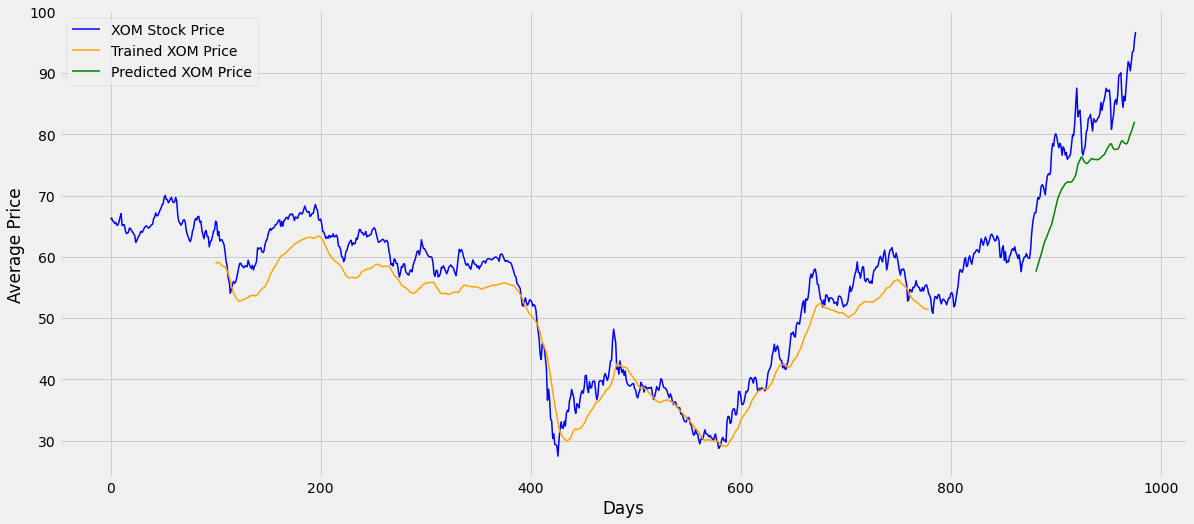

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(XOM_partial_ds1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(XOM_partial_ds1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(XOM_partial_ds1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.plot(scaler.inverse_transform(XOM_partial_ds1),color = 'blue',label = 'XOM Stock Price',linewidth=1.5)
plt.plot(trainPredictPlot, color = 'orange', label = 'Trained XOM Price',linewidth=1.5 )
plt.plot(testPredictPlot, color = 'green', label = 'Predicted XOM Price',linewidth=1.5 )
plt.legend()
plt.show()

In [31]:
len(test_data) #Based on 100 previous days

196

In [32]:
#Test data from 196-100(Prev 100days),so it starts from 102 day
x_input=test_data[96:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
#Creating list of last 100 data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
print(len(test_data[96:]))

100


In [35]:
print(len(temp_input))

100


In [36]:
actual=XOM_partial_ds1[training_size+101:len(XOM_partial_ds1),:1]
actual=scaler.inverse_transform(actual)

predict=test_predict

In [37]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(95):
    print(f'{actual[i]}  \t\t {predict[i]} ')

   Actual                    Predicted
------------------------------------------------
[68.58436013]  		 [57.58551918] 
[69.68819092]  		 [58.07462685] 
[69.42141006]  		 [58.66040538] 
[69.82035627]  		 [59.31015266] 
[71.41614025]  		 [59.83567211] 
[71.7783703]  		 [60.34449935] 
[71.56544495]  		 [60.99698646] 
[70.87279149]  		 [61.68632054] 
[70.13608766]  		 [62.27667721] 
[71.99375554]  		 [62.73645059] 
[73.20282892]  		 [63.0794197] 
[73.56751036]  		 [63.52262672] 
[73.38149263]  		 [64.02094195] 
[73.82205281]  		 [64.47800382] 
[77.11151838]  		 [64.84713379] 
[78.47723553]  		 [65.27044158] 
[78.10031212]  		 [65.99733516] 
[79.71078483]  		 [66.76737506] 
[80.0950395]  		 [67.4119752] 
[79.53211115]  		 [68.17004236] 
[78.5256438]  		 [68.93617756] 
[77.81046939]  		 [69.55417525] 
[78.54049355]  		 [69.99565774] 
[78.06288078]  		 [70.3731245] 
[76.59046422]  		 [70.80700129] 
[77.92924728]  		 [71.16967356] 
[77.64961639]  		 [71.36154737] 
[76.6102599]  		 [71.682204

# SVR Model : JNJ (Partial)

In [38]:
JNJ_partial_ds=pd.read_csv('dataset/JNJ.csv')

### 1.1 Date Extration Within 2018-07-12 - 2022-07-12

In [39]:
mask=(JNJ_partial_ds['Date'] >= '2018-07-12') & (JNJ_partial_ds['Date'] <= '2022-07-12')
JNJ_partial_ds=JNJ_partial_ds.loc[mask]
print(JNJ_partial_ds)

             Date        Open        High         Low       Close    Volume  \
14229  2018-07-12  114.945321  115.395352  114.459293  114.990326   6199000   
14230  2018-07-13  112.794193  114.756301  112.794193  113.343224   8250200   
14231  2018-07-16  113.406212  113.496216  111.750125  112.227150   7314400   
14232  2018-07-17  115.683361  117.492455  114.810311  116.205391  12858700   
14233  2018-07-18  115.935366  116.151383  114.459286  115.026321   7152000   
...           ...         ...         ...         ...         ...       ...   
15231  2022-07-06  178.070007  179.440002  177.410004  178.300003   5335600   
15232  2022-07-07  177.860001  179.119995  177.509995  178.500000   5725800   
15233  2022-07-08  178.330002  179.990005  177.770004  178.279999   3828300   
15234  2022-07-11  177.699997  179.020004  177.520004  178.350006   3645200   
15235  2022-07-12  177.979996  178.449997  175.199997  175.850006   4708800   

       Dividends  Stock Splits  
14229        0.0  

### 1.2 Create Average column

In [40]:
average=(JNJ_partial_ds['Open']+JNJ_partial_ds['High']+JNJ_partial_ds['Low']+JNJ_partial_ds['Close'])/4
y=average.values
JNJ_partial_ds.insert(8, "Average", average, True)

### 1.3 Drop OHLC column

In [41]:
#Drop columns - Date,Volume,Dividends,Stock Splits 
df=JNJ_partial_ds.drop(['Open', 'High', 'Low', 'Close','Dividends','Stock Splits','Volume'], axis=1)
JNJ_partial_ds_Ori=df
JNJ_partial_ds1=df

In [42]:
df

,Date,Average
14229,2018-07-12,114.947573
14230,2018-07-13,113.421978
14231,2018-07-16,112.719926
14232,2018-07-17,116.047880
14233,2018-07-18,115.393089
...,...,...
15231,2022-07-06,178.305004
15232,2022-07-07,178.247498
15233,2022-07-08,178.592503
15234,2022-07-11,178.147503


In [43]:
#Pick up only 'Average' column
JNJ_partial_ds1=df.reset_index()['Average'] 

### 1.4 Dateset Size

In [44]:
JNJ_partial_ds1.shape

(1007,)

# 2. Data Preprocessing

### 2.1 MinMaxScaler

In [45]:
#Use MinMaxScaler to scale the data range to 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
JNJ_partial_ds1=scaler.fit_transform(np.array(JNJ_partial_ds1).reshape(-1,1)) #Fit to data, then transform it

#### Exclude 30 days data 

In [46]:
JNJ_partial_ds1_Future=JNJ_partial_ds1[-30:]
JNJ_partial_ds1=JNJ_partial_ds1[:-30] #Exclude 30 days

In [47]:
#df1 have already converted to array and have the values between 0 to 1
JNJ_partial_ds1

array([[0.09711152],
       [0.07714941],
       [0.0679632 ],
       [0.1115088 ],
       [0.102941  ],
       [0.08589361],
       [0.07226187],
       [0.07844471],
       [0.10453078],
       [0.1082701 ],
       [0.12773118],
       [0.13506265],
       [0.14669243],
       [0.15116763],
       [0.15369978],
       [0.14828214],
       [0.14386588],
       [0.14524964],
       [0.14410129],
       [0.13980265],
       [0.13915527],
       [0.13532766],
       [0.12902685],
       [0.12107736],
       [0.12360942],
       [0.14451354],
       [0.16559442],
       [0.19156249],
       [0.19789272],
       [0.18373072],
       [0.18090456],
       [0.18894194],
       [0.19554673],
       [0.18727757],
       [0.18778164],
       [0.19308686],
       [0.18837436],
       [0.18345433],
       [0.1897968 ],
       [0.20793573],
       [0.21587902],
       [0.22397049],
       [0.22992771],
       [0.24335385],
       [0.25067446],
       [0.24966673],
       [0.24945947],
       [0.257

In [48]:
len(JNJ_partial_ds1)

977

### 2.2 Preparation of Training and Testing set

In [49]:
del training_size, test_size,train_data,test_data
training_size=int(len(JNJ_partial_ds1)*0.8) #Split train into 80%
test_size=len(JNJ_partial_ds1)-training_size 
train_data,test_data=JNJ_partial_ds1[0:training_size,:],JNJ_partial_ds1[training_size:len(JNJ_partial_ds1),:1]

#### Training and Testing size

In [50]:
training_size,test_size

(781, 196)

In [51]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#Converting independent and dependent feature based on time steps
time_step=100 #Predict based on 100 days
X_train,y_train=create_dataset(train_data,time_step)
X_test,ytest=create_dataset(test_data,time_step)

100
(0)
DataX 
----------------
 [0.09711152 0.07714941 0.0679632  0.1115088  0.102941   0.08589361
 0.07226187 0.07844471 0.10453078 0.1082701  0.12773118 0.13506265
 0.14669243 0.15116763 0.15369978 0.14828214 0.14386588 0.14524964
 0.14410129 0.13980265 0.13915527 0.13532766 0.12902685 0.12107736
 0.12360942 0.14451354 0.16559442 0.19156249 0.19789272 0.18373072
 0.18090456 0.18894194 0.19554673 0.18727757 0.18778164 0.19308686
 0.18837436 0.18345433 0.1897968  0.20793573 0.21587902 0.22397049
 0.22992771 0.24335385 0.25067446 0.24966673 0.24945947 0.25719528
 0.25950714 0.26896142 0.28209167 0.26851676 0.24845144 0.23819662
 0.23449187 0.22980869 0.24036015 0.25473524 0.25197902 0.23724824
 0.24602138 0.24270159 0.23908614 0.23878924 0.20328234 0.17844546
 0.18357249 0.20553501 0.22880137 0.24160488 0.23887848 0.23707083
 0.23401732 0.23286165 0.22337755 0.22180653 0.22275503 0.24326476
 0.25882523 0.25968493 0.26558272 0.26744998 0.27648942 0.29931151
 0.31030751 0.31356783 0.3167


DataY 
----------------
 0.2087314156444251

100
(335)
DataX 
----------------
 [0.20212774 0.20148821 0.19649356 0.19058478 0.18744742 0.21318405
 0.22981369 0.23535689 0.24217905 0.25061604 0.26773252 0.27406045
 0.26792644 0.27997923 0.28071521 0.27912059 0.27268027 0.29715348
 0.30006695 0.31316244 0.31586123 0.31567723 0.32432531 0.32717769
 0.32454024 0.33456845 0.35073069 0.35195765 0.36790458 0.38891247
 0.3849258  0.38161332 0.38142948 0.38418988 0.37888419 0.37719741
 0.38081598 0.35999267 0.3569257  0.35898027 0.37029686 0.37845474
 0.37759594 0.37698309 0.38072419 0.39342083 0.40449197 0.4175564
 0.42246362 0.40286671 0.40890844 0.41406075 0.41084056 0.42295448
 0.43408707 0.43298261 0.42473306 0.43105095 0.45472646 0.46699376
 0.47919977 0.46454034 0.45257956 0.45828391 0.45162883 0.43672422
 0.43460827 0.43132646 0.42237138 0.41399934 0.42025535 0.40369752
 0.38690752 0.37956198 0.33808133 0.25336015 0.28727957 0.28956358
 0.32740273 0.33786511 0.3242851  0.28237256 0.31


DataY 
----------------
 0.6932775569144651

100
(638)
DataX 
----------------
 [0.67450334 0.7453197  0.7205907  0.72263817 0.65308184 0.65935109
 0.63900054 0.61713801 0.62441514 0.66779323 0.67138454 0.68171712
 0.69844465 0.69119921 0.67793701 0.68269369 0.6755741  0.67582635
 0.66413931 0.64256606 0.6392061  0.65438981 0.65844709 0.62440285
 0.62614671 0.61597132 0.58823499 0.54766122 0.55802678 0.5891226
 0.59711064 0.60662007 0.61612971 0.61660525 0.61961662 0.63362733
 0.63080609 0.62849233 0.62712898 0.61368869 0.62376892 0.6354024
 0.6455141  0.66453331 0.68681708 0.68488354 0.68006517 0.65828862
 0.66763951 0.66925632 0.66852702 0.66589612 0.64101306 0.63806494
 0.59891757 0.60715927 0.63356369 0.64281959 0.65071266 0.67331346
 0.70149336 0.69122321 0.68548596 0.68038231 0.66396236 0.65245606
 0.66031729 0.66526203 0.67642017 0.7013665  0.71607478 0.71258771
 0.72891242 0.75148151 0.74434944 0.73106823 0.7314166  0.75956469
 0.7580115  0.75274953 0.74279663 0.75579266 0.767

#### Training Shape

In [52]:
print(f'x_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

x_train shape : (680, 100)
y_train shape : (680,)


#### Testing Shape

In [53]:
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {ytest.shape}')

X_test shape : (95, 100)
y_test shape : (95,)


# 3. Modelling

### 3.1 Create the SVR model

In [54]:
# create the model object
model = SVR(C=20, degree=2, gamma=0.01)

### 3.2 Training SVR Model

In [55]:
model.fit(X_train, y_train)

SVR(C=20, degree=2, gamma=0.01)

####  Hyperparameter tuning

In [56]:
# defining parameter range
param_grid = {'C': [5,10,20,50,100,200,500,1000], 
              'gamma': [0.001,0.01,0.1,0.5,0.8,1,3],
              'degree':[2,3],
              'kernel': ['rbf','linear','poly']} 
  
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.161 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.165 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.225 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=0.546 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=rbf;, score=-0.411 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=0.001, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=0.001, kernel=poly;, score=-1.624 to

[CV 5/5] END C=5, degree=2, gamma=3, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.492 total time=   0.0s
[CV 2/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.522 total time=   0.0s
[CV 3/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.362 total time=   0.0s
[CV 4/5] END C=5, degree=2, gamma=3, kernel=poly;, score=0.237 total time=   0.0s
[CV 5/5] END C=5, degree=2, gamma=3, kernel=poly;, score=-4.977 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.161 total time=   0.0s
[CV 2/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.165 total time=   0.0s
[CV 3/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.225 total time=   0.0s
[CV 4/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=0.546 total time=   0.0s
[CV 5/5] END C=5, degree=3, gamma=0.001, kernel=rbf;, score=-0.411 total time=   0.0s
[CV 1/5] END C=5, degree=3, gamma=0.001, kernel=linear;, score=0.576 total time

[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=0.574 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=0.007 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-1.071 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-1.262 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-0.139 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=-0.361 total time=   0.0s
[CV 5/5] END C=10, degree=2, ga

[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=rbf;, score=0.377 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=rbf;, score=0.435 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.1, kernel=rbf;, score=0.290 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=rbf;, score=0.405 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=rbf;, score=-1.461 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.1, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=poly;, score=0.053 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=poly;, score

[CV 2/5] END C=20, degree=2, gamma=0.8, kernel=poly;, score=0.522 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=0.8, kernel=poly;, score=0.362 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=0.8, kernel=poly;, score=0.237 total time=   0.0s
[CV 5/5] END C=20, degree=2, gamma=0.8, kernel=poly;, score=-4.977 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=1, kernel=rbf;, score=-1.651 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=1, kernel=rbf;, score=-0.015 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=1, kernel=rbf;, score=-0.054 total time=   0.0s
[CV 4/5] END C=20, degree=2, gamma=1, kernel=rbf;, score=0.337 total time=   0.0s
[CV 5/5] END C=20, degree=2, gamma=1, kernel=rbf;, score=-24.319 total time=   0.0s
[CV 1/5] END C=20, degree=2, gamma=1, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=20, degree=2, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=20, degree=2, gamma=1, kernel=linear;, score=0.377 total ti

[CV 3/5] END C=20, degree=3, gamma=1, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=1, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=1, kernel=poly;, score=0.050 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=1, kernel=poly;, score=0.098 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=1, kernel=poly;, score=0.390 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=1, kernel=poly;, score=-0.941 total time=   0.0s
[CV 5/5] END C=20, degree=3, gamma=1, kernel=poly;, score=-19.110 total time=   0.0s
[CV 1/5] END C=20, degree=3, gamma=3, kernel=rbf;, score=-5.613 total time=   0.0s
[CV 2/5] END C=20, degree=3, gamma=3, kernel=rbf;, score=-0.558 total time=   0.0s
[CV 3/5] END C=20, degree=3, gamma=3, kernel=rbf;, score=-0.505 total time=   0.0s
[CV 4/5] END C=20, degree=3, gamma=3, kernel=rbf;, score=-0.129 total time=   

[CV 5/5] END C=50, degree=2, gamma=0.8, kernel=poly;, score=-4.977 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=1, kernel=rbf;, score=-1.651 total time=   0.0s
[CV 2/5] END C=50, degree=2, gamma=1, kernel=rbf;, score=-0.015 total time=   0.0s
[CV 3/5] END C=50, degree=2, gamma=1, kernel=rbf;, score=-0.054 total time=   0.0s
[CV 4/5] END C=50, degree=2, gamma=1, kernel=rbf;, score=0.337 total time=   0.0s
[CV 5/5] END C=50, degree=2, gamma=1, kernel=rbf;, score=-24.319 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=1, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=50, degree=2, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=50, degree=2, gamma=1, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=50, degree=2, gamma=1, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=50, degree=2, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=50, degree=2, gamma=1, kernel=poly;, score=0.494 total time

[CV 1/5] END C=50, degree=3, gamma=1, kernel=poly;, score=0.050 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=1, kernel=poly;, score=0.098 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=1, kernel=poly;, score=0.390 total time=   0.0s
[CV 4/5] END C=50, degree=3, gamma=1, kernel=poly;, score=-0.941 total time=   0.0s
[CV 5/5] END C=50, degree=3, gamma=1, kernel=poly;, score=-19.110 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=3, kernel=rbf;, score=-5.613 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=3, kernel=rbf;, score=-0.558 total time=   0.0s
[CV 3/5] END C=50, degree=3, gamma=3, kernel=rbf;, score=-0.505 total time=   0.0s
[CV 4/5] END C=50, degree=3, gamma=3, kernel=rbf;, score=-0.129 total time=   0.0s
[CV 5/5] END C=50, degree=3, gamma=3, kernel=rbf;, score=-32.159 total time=   0.0s
[CV 1/5] END C=50, degree=3, gamma=3, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=50, degree=3, gamma=3, kernel=linear;, score=0.664 total time=   0

[CV 1/5] END C=100, degree=2, gamma=1, kernel=rbf;, score=-1.651 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=rbf;, score=-0.015 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf;, score=-0.054 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=rbf;, score=0.337 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=1, kernel=rbf;, score=-24.319 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=1, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=1, kernel=poly;, score=0.494 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=poly;, score=0.522 t

[CV 5/5] END C=100, degree=3, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=1, kernel=poly;, score=0.050 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=poly;, score=0.098 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=poly;, score=0.390 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=1, kernel=poly;, score=-0.941 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=1, kernel=poly;, score=-19.110 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=3, kernel=rbf;, score=-5.613 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=3, kernel=rbf;, score=-0.558 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=3, kernel=rbf;, score=-0.505 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=3, kernel=rbf;, score=-0.129 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=3, kernel=rbf;, score=-32.159 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=3, kernel=linear;, score=0.576 tot

[CV 3/5] END C=200, degree=3, gamma=0.01, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.01, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=200, degree=3, gamma=0.01, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.01, kernel=poly;, score=-0.260 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.01, kernel=poly;, score=-0.015 total time=   0.0s
[CV 3/5] END C=200, degree=3, gamma=0.01, kernel=poly;, score=0.254 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.01, kernel=poly;, score=-0.544 total time=   0.0s
[CV 5/5] END C=200, degree=3, gamma=0.01, kernel=poly;, score=-24.869 total time=   0.0s
[CV 1/5] END C=200, degree=3, gamma=0.1, kernel=rbf;, score=0.377 total time=   0.0s
[CV 2/5] END C=200, degree=3, gamma=0.1, kernel=rbf;, score=0.435 total time=   0.0s
[CV 3/5] END C=200, degree=3, gamma=0.1, kernel=rbf;, score=0.290 total time=   0.0s
[CV 4/5] END C=200, degree=3, gamma=0.

[CV 3/5] END C=500, degree=2, gamma=0.5, kernel=poly;, score=0.362 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=0.5, kernel=poly;, score=0.237 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=0.5, kernel=poly;, score=-4.938 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=0.8, kernel=rbf;, score=-1.131 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=0.8, kernel=rbf;, score=0.027 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=0.8, kernel=rbf;, score=0.076 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=0.8, kernel=rbf;, score=0.396 total time=   0.0s
[CV 5/5] END C=500, degree=2, gamma=0.8, kernel=rbf;, score=-21.786 total time=   0.0s
[CV 1/5] END C=500, degree=2, gamma=0.8, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=500, degree=2, gamma=0.8, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=500, degree=2, gamma=0.8, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=500, degree=2, gamma=0.8, kernel=l

[CV 2/5] END C=500, degree=3, gamma=0.8, kernel=poly;, score=0.097 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=0.8, kernel=poly;, score=0.390 total time=   0.0s
[CV 4/5] END C=500, degree=3, gamma=0.8, kernel=poly;, score=-0.943 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=0.8, kernel=poly;, score=-19.119 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-1.651 total time=   0.0s
[CV 2/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-0.015 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-0.054 total time=   0.0s
[CV 4/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=0.337 total time=   0.0s
[CV 5/5] END C=500, degree=3, gamma=1, kernel=rbf;, score=-24.319 total time=   0.0s
[CV 1/5] END C=500, degree=3, gamma=1, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=500, degree=3, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=500, degree=3, gamma=1, kernel=linear;, score=

[CV 3/5] END C=1000, degree=2, gamma=3, kernel=rbf;, score=-0.505 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=3, kernel=rbf;, score=-0.129 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=3, kernel=rbf;, score=-32.159 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=3, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=3, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=3, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=3, kernel=linear;, score=0.738 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=3, kernel=linear;, score=0.277 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=0.492 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=0.522 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=3, kernel=poly;, score=0.362 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=3, kernel=poly;, 

[CV 3/5] END C=1000, degree=3, gamma=1, kernel=poly;, score=0.390 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=1, kernel=poly;, score=-0.941 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=poly;, score=-19.110 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=3, kernel=rbf;, score=-5.613 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=3, kernel=rbf;, score=-0.558 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=3, kernel=rbf;, score=-0.505 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=3, kernel=rbf;, score=-0.129 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=3, kernel=rbf;, score=-32.159 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=0.576 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=3, kernel=linear;, score=0.377 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=3, kernel=linear;,

GridSearchCV(estimator=SVR(C=20, degree=2, gamma=0.01),
             param_grid={'C': [5, 10, 20, 50, 100, 200, 500, 1000],
                         'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 0.8, 1, 3],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [57]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 20, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
SVR(C=20, degree=2, gamma=0.01)


# 4. Evaluation

# 4.1 Model Accuracy

In [58]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [59]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1)) #Ouput of train dataset
test_predict=scaler.inverse_transform(test_predict.reshape(-1,1)) #Ouput of test dataset

In [60]:
#Transform y train and y test to ori form
y_trainOri=scaler.inverse_transform(y_train.reshape(-1,1))
y_testOri=scaler.inverse_transform(ytest.reshape(-1,1))

#### i - RMSE Performance

In [61]:
training_performance_RMSE=math.sqrt(mean_squared_error(y_trainOri,train_predict)) #Train
testing_performance_RMSE=math.sqrt(mean_squared_error(y_testOri,test_predict)) #Test
print(f'Training Performance for RMSE is >> {training_performance_RMSE:.4f}')
print(f'Testing Performance for RMSE is  >> {testing_performance_RMSE:.4f}')

Training Performance for RMSE is >> 3.4937
Testing Performance for RMSE is  >> 3.7485


#### ii - MAPE Performance

In [62]:
training_performance_MAPE= np.mean(np.abs((train_predict - y_trainOri)/train_predict))*100
testing_performance_MAPE= np.mean(np.abs((test_predict - y_testOri)/test_predict))*100
print(f'Training Performance for MAPE is >> {training_performance_MAPE:.4f}')
print(f'Testing Performance for MAPE is  >> {testing_performance_MAPE:.4f}')

Training Performance for MAPE is >> 2.0837
Testing Performance for MAPE is  >> 1.7861


# 4.2 Visualizing the Predicted Average Prices

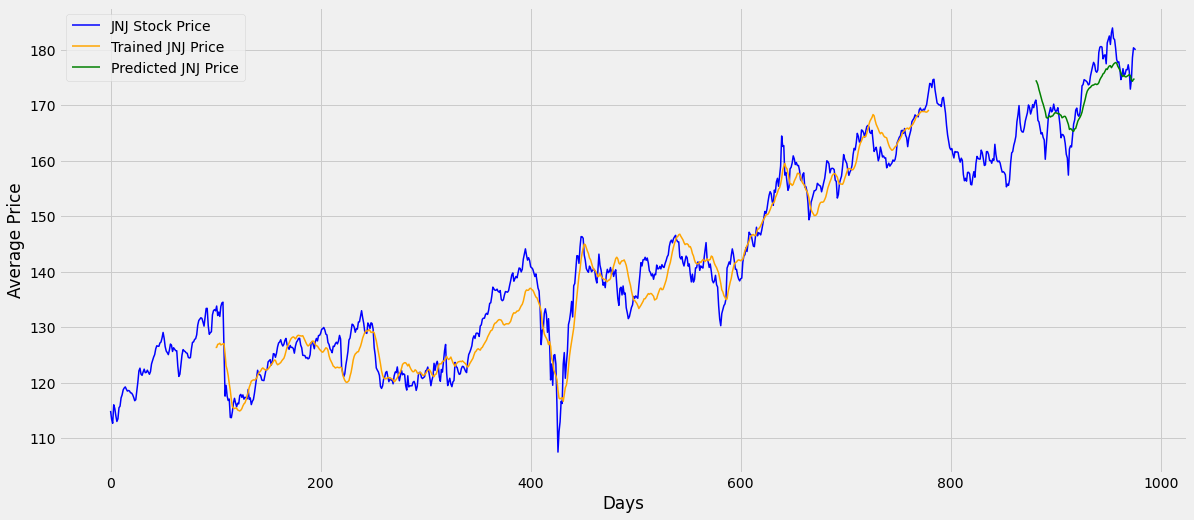

In [63]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(JNJ_partial_ds1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(JNJ_partial_ds1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(JNJ_partial_ds1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.plot(scaler.inverse_transform(JNJ_partial_ds1),color = 'blue',label = 'JNJ Stock Price',linewidth=1.5)
plt.plot(trainPredictPlot, color = 'orange', label = 'Trained JNJ Price',linewidth=1.5 )
plt.plot(testPredictPlot, color = 'green', label = 'Predicted JNJ Price',linewidth=1.5 )
plt.legend()
plt.show()

In [64]:
#Test data from 196-100(Prev 100days),so it starts from 102 day
x_input=test_data[96:].reshape(1,-1)
x_input.shape

(1, 100)

In [65]:
#Creating list of last 100 data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [66]:
actual=JNJ_partial_ds1[training_size+101:len(JNJ_partial_ds1),:1]
actual=scaler.inverse_transform(actual)

predict=test_predict

In [67]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(95):
    print(f'{actual[i]}  \t\t {predict[i]} ')

   Actual                    Predicted
------------------------------------------------
[169.74757557]  		 [174.51990145] 
[167.29911898]  		 [174.17883344] 
[167.00787712]  		 [173.66845251] 
[165.92927269]  		 [172.84447015] 
[164.85808139]  		 [172.17655657] 
[165.07775713]  		 [171.42869447] 
[164.21635351]  		 [170.75413291] 
[163.76961724]  		 [170.2121001] 
[160.28452212]  		 [169.55220815] 
[162.89586645]  		 [168.8608523] 
[165.70714049]  		 [167.82926627] 
[168.05685669]  		 [167.69411789] 
[168.77262429]  		 [167.87327539] 
[169.62169711]  		 [168.11170161] 
[168.83186642]  		 [167.90077829] 
[169.08608767]  		 [168.05737101] 
[170.22639822]  		 [168.08547616] 
[169.25146371]  		 [168.35624855] 
[168.87876383]  		 [168.64422351] 
[169.08609423]  		 [168.66171917] 
[169.57727504]  		 [168.61368394] 
[168.12103954]  		 [168.49598497] 
[166.48462581]  		 [168.51798054] 
[164.15712035]  		 [168.33426624] 
[164.76429012]  		 [168.20713763] 
[164.69025691]  		 [167.76009934] 
[164